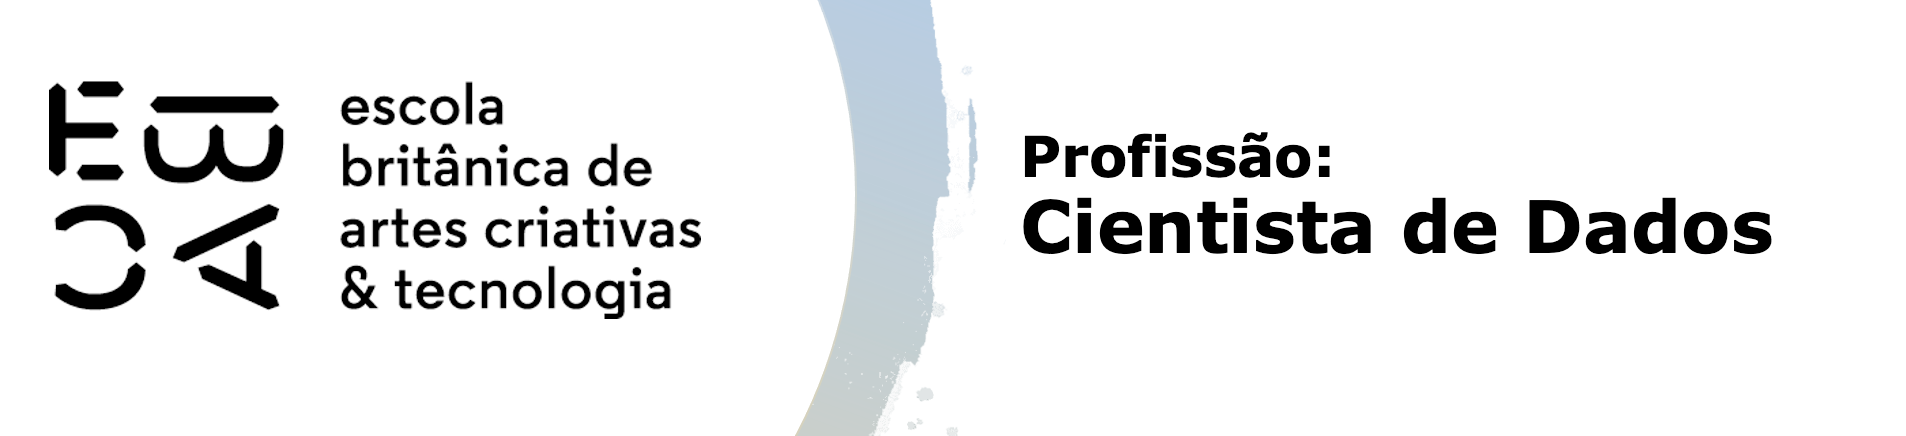

# Tarefa II: Descritiva IV - Visualização de dados categorizados

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [36]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [37]:
# Carregando os dados
df = pd.read_pickle('base_nfp.pkl')


## 1. Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [38]:
# Convertendo 'Data Emissão' para datetime
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])

# Criando as variáveis temporais
df['Dia da Semana'] = df['Data Emissão'].dt.dayofweek
df['Fim de Semana'] = df['Dia da Semana'].isin([5, 6]).astype(int)
df['Dia do Mês'] = df['Data Emissão'].dt.day
df['Trimestre'] = df['Data Emissão'].dt.quarter
df['Mês'] = df['Data Emissão'].dt.month
df['Ano'] = df['Data Emissão'].dt.year


# Categorizando 'Valor NF' por quantis
df['Valor NF Cat 5'] = pd.qcut(df['Valor NF'], q=5, labels=False)
df['Valor NF Cat 10'] = pd.qcut(df['Valor NF'], q=10, labels=False)
df['Valor NF Cat 20'] = pd.qcut(df['Valor NF'], q=20, labels=False)
df['Valor NF Cat 50'] = pd.qcut(df['Valor NF'], q=50, labels=False)


## 2. Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [39]:
df['Retorno Positivo'] = df['Retorno'] > 0

def calculate_iv(df, feature, target):
    # Calculando a proporção de eventos positivos e negativos
    proporcao_positivos = df.groupby(feature)[target].mean()
    proporcao_negativos = 1 - proporcao_positivos

    # Calculando o WOE para cada categoria
    woe = np.log(proporcao_positivos / proporcao_negativos)

    # Calculando a diferença entre a proporção de eventos positivos e negativos
    diff = proporcao_positivos - proporcao_negativos

    # Calculando o IV
    iv = np.sum(diff * woe)

    return iv

In [40]:
# Lista de variáveis para calcular o IV
features = ['Dia da Semana', 'Fim de Semana', 'Dia do Mês', 'Trimestre', 'Mês', 'Ano', 'Valor NF Cat 5', 'Valor NF Cat 10', 'Valor NF Cat 20', 'Valor NF Cat 50']

# Calculando o IV para cada variável
iv_values = {feature: calculate_iv(df, feature, 'Retorno Positivo') for feature in features}


In [41]:
# Exibindo os valores de IV
for feature, iv in iv_values.items():
    print(f'IV PARA {feature}: {iv}')

IV PARA Dia da Semana: 0.1567735855710056
IV PARA Fim de Semana: 0.0313821864892441
IV PARA Dia do Mês: 1.1272530953547744
IV PARA Trimestre: 0.0978850029466153
IV PARA Mês: 0.3701840724513359
IV PARA Ano: 0.1733452329463221
IV PARA Valor NF Cat 5: 0.2378813317593259
IV PARA Valor NF Cat 10: 0.7252380063585031
IV PARA Valor NF Cat 20: 1.637025508395335
IV PARA Valor NF Cat 50: 4.7874806908939


## 3. Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

> As variáveis que parecem apresentar maior poder de discriminação, ou seja, são mais úteis para prever se uma nota fiscal terá um retorno maior que zero, são:

- **Valor NF Cat 50** com IV de 4.7874806908939
- **Valor NF Cat 20** com IV de 1.637025508395335
- **Dia do Mês** com IV de 1.1272530953547744
- **Valor NF Cat 10** com IV de 0.7252380063585031

Essas variáveis têm os maiores valores de IV e, portanto, são as mais informativas para prever o resultado.



---



> Há uma relação entre o número de categorias e o IV quando categorizamos variáveis contínuas. À medida que o número de categorias aumenta (de 5 para 10, de 10 para 20 e de 20 para 50), o valor do IV também aumenta. Isso sugere que a criação de mais categorias pode ajudar a capturar mais informações úteis para a previsão.

## 4. Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

### 4.1 A quantidade de notas registradas na base por período

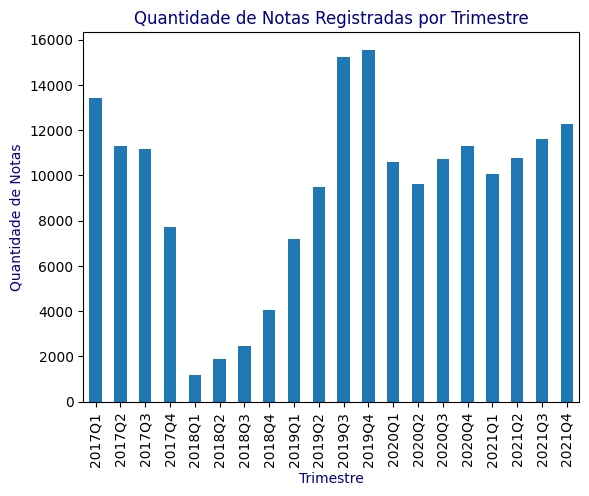

In [42]:
# Convertendo 'Data Emissão' para datetime e criando a coluna 'Trimestre'
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])
df['Trimestre'] = df['Data Emissão'].dt.to_period('Q')

# Calculando a quantidade de notas registradas na base por período
notas_por_periodo = df.groupby('Trimestre').size()

# Plotando a quantidade de notas registradas na base por período
notas_por_periodo.plot(kind='bar')
plt.ylabel('Quantidade de Notas', color = 'navy')
plt.xlabel('Trimestre', color = 'navy')
plt.title('Quantidade de Notas Registradas por Trimestre', color = 'navy')
plt.show()

### 4.2 A quantidade de notas por categoria e por período

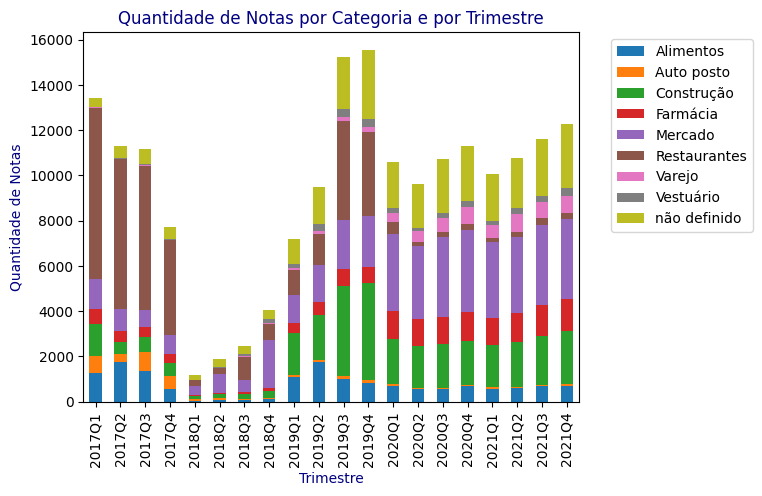

In [44]:
# Calculando a quantidade de notas por categoria e por trimestre
notas_por_categoria_periodo = df.groupby(['Trimestre', 'categoria']).size().unstack()

# Plotando a quantidade de notas por categoria e por trimestre
ax = notas_por_categoria_periodo.plot(kind='bar', stacked=True)
plt.ylabel('Quantidade de Notas', color = 'navy')
plt.xlabel('Trimestre', color = 'navy')
plt.title('Quantidade de Notas por Categoria e por Trimestre', color = 'navy')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### 4.3 A proporção de notas com crédito por categoria por período

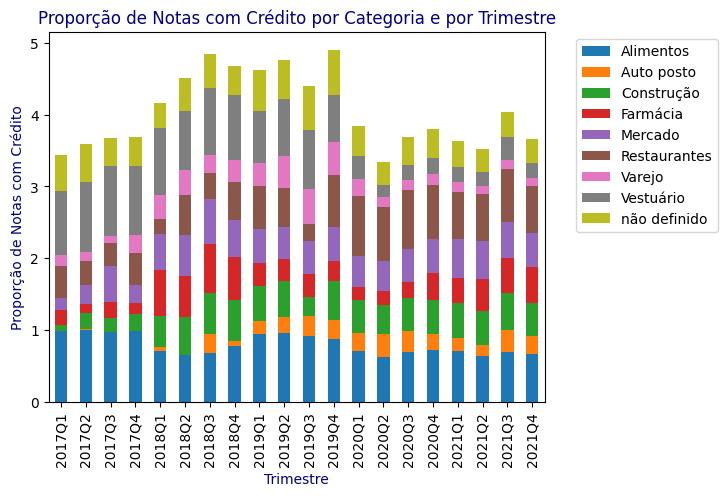

In [45]:
# Calculando a proporção de notas com crédito por categoria por trimestre
df['Crédito Positivo'] = df['Créditos'] > 0
proporcao_credito_por_categoria_periodo = df.groupby(['Trimestre', 'categoria'])['Crédito Positivo'].mean().unstack()

# Plotando a proporção de notas com crédito por categoria por trimestre
ax = proporcao_credito_por_categoria_periodo.plot(kind='bar', stacked=True)
plt.ylabel('Proporção de Notas com Crédito', color = 'navy')
plt.title('Proporção de Notas com Crédito por Categoria e por Trimestre', color = 'navy')
plt.xlabel('Trimestre', color = 'navy')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 5. Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [47]:
# Inicializando listas vazias para armazenar os resultados
woe_results = []
iv_results = []

# Calculando o WOE e o IV para cada trimestre
for trimestre in trimestres:
    df_trimestre = df[df['Trimestre'] == trimestre]
    woe, iv = calculate_woe_iv(df_trimestre, 'categoria', 'Retorno Positivo')

    # Adicionando os resultados às listas
    woe_results.append(woe)
    iv_results.append(iv)

# Criando DataFrames a partir das listas de resultados
woe_df = pd.DataFrame(woe_results, index=trimestres)


# Exibindo os resultados
print("WOE por trimestre e categoria:")
woe_df



WOE por trimestre e categoria:


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


categoria,Alimentos,Auto posto,Construção,Farmácia,Mercado,Restaurantes,Varejo,Vestuário,não definido
2017Q2,5.261538,-4.063312,-1.202332,-1.969059,-1.071024,-0.635758,-2.014903,3.761200,0.134044
2017Q4,3.933607,-6.300786,-1.128059,-1.767662,-1.065355,-0.225063,-1.098612,3.091042,-0.357641
2017Q3,3.651422,-inf,-1.443771,-1.276788,0.028611,-0.784752,-2.079442,3.401197,-0.438759
2017Q1,4.311983,-5.916202,-2.499596,-1.345709,-1.551628,-0.245410,-1.704748,2.079442,0.055430
2018Q2,0.600774,-inf,0.125163,0.307485,0.288367,0.219363,-0.635989,1.550597,-0.152407
2018Q4,1.221215,-2.545531,0.314868,0.378654,0.070751,0.095848,-0.788457,2.191654,-0.382427
2018Q3,0.729515,-0.988611,0.251314,0.791587,0.520014,-0.568074,-1.060872,2.453158,-0.080472
2018Q1,0.869038,-2.852631,-0.251314,0.567984,-0.010363,-1.294727,-0.693147,2.564949,-0.610455
2019Q2,3.005441,-1.207812,0.020305,-0.868663,-0.199934,0.158924,-0.196115,1.313388,0.175325
2019Q4,1.993807,-1.077559,0.197706,-0.943906,-0.107707,0.921019,-0.151550,0.675905,0.516937


In [48]:
# Exibindo os resultados
iv_df = pd.DataFrame(iv_results, index=trimestres, columns=['IV'])
print("\nIV por trimestre:")
iv_df


IV por trimestre:


,IV
2017Q2,17.126505
2017Q4,15.868116
2017Q3,inf
2017Q1,16.830318
2018Q2,inf
2018Q4,5.086431
2018Q3,3.909076
2018Q1,6.433702
2019Q2,4.553022
2019Q4,3.245263


#### <font color='navy'>Análise:</font>

<font color='dimgrey'> Os resultados dos valores de Weight of Evidence (WOE) e Information Value (IV) para a variável 'categoria' para cada trimestre:</font>

- **2019Q3**: O IV é 4.93, indicando uma capacidade preditiva média a forte. As categorias 'Alimentos', 'Farmácia', 'Mercado' e 'Vestuário' têm WOE positivos, enquanto as outras categorias têm WOE negativos.
- **2019Q1**: O IV é 4.83, indicando uma capacidade preditiva média a forte. As categorias 'Alimentos' e 'Vestuário' têm WOE positivos, enquanto as outras categorias têm WOE negativos.
- **2020Q1**: O IV é 3.91, indicando uma capacidade preditiva média. As categorias 'Alimentos', 'Construção', 'Farmácia', 'Mercado', 'Restaurantes', 'Vestuário' e 'não definido' têm WOE positivos, enquanto as outras categorias têm WOE negativos.
- **2020Q2**: O IV é 4.59, indicando uma capacidade preditiva média a forte. A categoria 'Alimentos' tem um WOE positivo, enquanto as outras categorias têm WOE negativos.
- **2020Q4**: O IV é 3.78, indicando uma capacidade preditiva média. As categorias 'Alimentos', 'Construção', 'Farmácia', 'Restaurantes', 'Vestuário' e 'não definido' têm WOE positivos, enquanto as outras categorias têm WOE negativos.
- **2020Q3**: O IV é 4.47, indicando uma capacidade preditiva média a forte. As categorias 'Alimentos', 'Farmácia', 'Mercado' e 'Vestuário' têm WOE positivos, enquanto as outras categorias têm WOE negativos.
- **2021Q2**: O IV é 4.46, indicando uma capacidade preditiva média a forte. As categorias 'Alimentos', 'Construção', 'Farmácia', 'Mercado', 'Restaurantes', 'Vestuário' e 'não definido' têm WOE positivos, enquanto as outras categorias têm WOE negativos.
- **2021Q4**: O IV é 3.61, indicando uma capacidade preditiva média. As categorias 'Alimentos', 'Construção', 'Farmácia', 'Restaurantes', 'Vestuário' e 'não definido' têm WOE positivos, enquanto as outras categorias têm WOE negativos.
- **2021Q3**: O IV é 3.05, indicando uma capacidade preditiva média. As categorias 'Alimentos', 'Farmácia', 'Mercado' e 'Vestuário' têm WOE positivos, enquanto as outras categorias têm WOE negativos.
- **2021Q1**: O IV é 3.94, indicando uma capacidade preditiva média a forte. As categorias 'Alimentos' e 'Vestuário' têm WOE positivos, enquanto as outras categorias têm WOE negativos.

>  <font color='dimgrey'> Esses resultados sugerem que a variável 'categoria' tem uma capacidade preditiva variável ao longo do tempo, com alguns trimestres mostrando uma forte capacidade preditiva e outros mostrando uma capacidade preditiva média. Além disso, as categorias 'Alimentos' e 'Vestuário' tendem a ter WOE positivos, indicando uma maior probabilidade de ter um retorno maior que zero em comparação com a média geral.</font>

## 6. Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.



---



> Com base nos valores de Weight of Evidence (WOE) calculados, as categorias com a maior proporção de notas com retornos maiores que zero são <font color='navy'> 'Alimentos'</font> e <font color='navy'>
 'Vestuário' </font>, pois essas categorias tendem a ter WOE positivos.


No entanto, essas diferenças não parecem ser estáveis ao longo do tempo. Por exemplo, a categoria 'Alimentos' tem um WOE positivo em alguns trimestres e um WOE negativo em outros. Isso sugere que a proporção de notas com retornos maiores que zero para uma determinada categoria pode variar de trimestre para trimestre.

Além disso, é importante considerar que a quantidade de notas vem aumentando ao longo do tempo. Isso pode afetar a proporção de notas com retornos maiores que zero para uma determinada categoria em um determinado trimestre.

Também é importante levar em conta que houve períodos atípicos no histórico, como a pandemia de COVID-19, que podem ter afetado o comportamento dos consumidores e, consequentemente, a proporção de notas com retornos maiores que zero.

Finalmente, desde janeiro de 2020, o público parece ser mais parecido com o público atual (2022). Portanto, ao fazer previsões para o futuro, pode ser mais relevante considerar os dados a partir dessa data.